In [11]:
# Import statements
import pandas as pd
import numpy as np 
import csv 
import json
import re
import math

In [2]:
'''
Loads the dataframe from Query 1 and Query 2 and merges + drops duplicates and NaNs
    @param: csv1: path to CSV 1 (formed by Query 1)
    @param: csv2: path to CSV 2 (formed by Query 2)
    @return: df1: a merged dataframe of csv1 and csv2
'''
def loadBacktestData(csv1, csv2):
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    df1 = df1.append(df2)
    df1_ = df1.drop_duplicates(subset=['Organization Name'])
    df1 = df1_[df1_.Founders.notna()]
    df1 = df1[df1.LinkedIn.notna()]
    df1 = df1.reset_index()
    for i in range(len(df1)):
        if df1.iloc[i].LinkedIn.count('about') > 0:
            df1['LinkedIn'][i] = df1['LinkedIn'][i].split('about')[0]
    df1 = df1.set_index('Organization Name')
    df1 = df1.drop('index', 1)
    df1['Organization Name'] = df1.index
    df1_ = df1_.set_index('Organization Name')
    return df1, df1_

# Loads and combines both CSVs into df1 dataframe
df1, df1_ = loadBacktestData('backtest1.csv', 'backtest2.csv')
df3, df3_ = loadBacktestData('FailedCompanies.csv', 'FailedCompanies.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
'''
Method to save the company data as a txt file (loadable as JSON)
    @param: data: company_data dictionary of Company objects
    @return: None
'''
def saveData(data, fileName):
    data_json = json.dumps(data, default=lambda x: x.__dict__)
    with open(fileName, 'w') as outfile:
        json.dump(data_json, outfile)

'''
Method to load company data into a dictionary (same structure as Company object)
    @param: dataFile: string path to saved txt file
    @return: dataDict: a dictionary with the same structure as a Company object
'''
def loadData(dataFile):
    with open(dataFile) as json_file:
        data = json.load(json_file)
    dataDict = json.loads(data)
    return dataDict

In [4]:
alldata = loadData('alldata_final.txt')
faileddata = loadData('failed1.txt')

In [5]:
'''
Structure of Company Dictionary Entry:
    @name - string for the company's name
    @description - string for a company description
    @founders - list of founder dictionaries (single founders)
        Structure of Founder Dictionary Entry
            @name - string for the founder's name
            @connections - string for the founder's # of connections
            @location - string for the founder's location 
            @education - list of education dictionaries (single education experiences)
                Structure of Education Dictionary Entry
                    @school - string for the school name
                    @degree - string for the degree objective (i.e. BS / BA)
                    @field - string for the field studied (i.e. Computer Science)
            @experience - list of experience dictionaries (single experiences)
                Structure of Experience Dictionary Entry
                    @companyName - string for the company's name
                    @title - string for the position held at the company
                    @dates - string for the dates worked at the company (i.e. May 2000 - Jun 2000)
    @industries - list of strings with the industries the company is involved in 
    @website - string for the company's website
    @lastStage - string for the last stage of funding received (i.e. Series A)
    @linkedin - string for the URL of the company's LI profile
    @location - string for the company's HQ location
'''
pass

In [14]:
df3_.index[0]

'JOANY'

In [10]:
'''
Data Validation: Location
    Please note: county can also mean 'state'
'''
drop_city = {} ; drop_country = {} ; keep_city = {} ; keep_country = {}
drop_county = {} ; keep_county = {}
for i in range(len(df1_)):
    split_item = df1_.iloc[i]['Headquarters Location'].split(',')
    if df1_.index[i] not in alldata:
        if split_item[0] not in drop_city:
            drop_city[split_item[0]] = 1
        else:
            drop_city[split_item[0]] += 1
        if split_item[-1] not in drop_country:
            drop_country[split_item[-1]] = 1
        else:
            drop_country[split_item[-1]] += 1
        if split_item[1] not in drop_county:
            drop_county[split_item[1]] = 1
        else:
            drop_county[split_item[1]] += 1
    else:
        if split_item[0] not in keep_city:
            keep_city[split_item[0]] = 1
        else:
            keep_city[split_item[0]] += 1
        if split_item[-1] not in keep_country:
            keep_country[split_item[-1]] = 1
        else:
            keep_country[split_item[-1]] += 1
        if split_item[1] not in keep_county:
            keep_county[split_item[1]] = 1
        else:
            keep_county[split_item[1]] += 1

drop_city = {k: v for k, v in sorted(drop_city.items(), key=lambda item: item[1], reverse=True)}
drop_country = {k: v for k, v in sorted(drop_country.items(), key=lambda item: item[1], reverse=True)}
keep_city = {k: v for k, v in sorted(keep_city.items(), key=lambda item: item[1], reverse=True)}
keep_country = {k: v for k, v in sorted(keep_country.items(), key=lambda item: item[1], reverse=True)}
drop_county = {k: v for k, v in sorted(keep_county.items(), key=lambda item: item[1], reverse=True)}
keep_county = {k: v for k, v in sorted(keep_county.items(), key=lambda item: item[1], reverse=True)}

for (i,j) in [(drop_country, keep_country), (drop_city, keep_city), (drop_county, keep_county)]:
    df_1 = pd.DataFrame.from_dict(i, orient='index', columns=['freq']).reset_index()
    df_2 = pd.DataFrame.from_dict(j, orient='index', columns=['freq']).reset_index()
    df_item = pd.merge(df_1, df_2, on='index')
    df_item.columns = ['name', 'dropped', 'kept']
    df_item['dropped'] /= df_item['dropped'].sum()
    df_item['kept'] /= df_item['kept'].sum()
    df_item.set_index(['name'])
df_item.head(10)

,name,dropped,kept
0,California,0.324667,0.324667
1,New York,0.084667,0.084667
2,England,0.058667,0.058667
3,Massachusetts,0.033333,0.033333
4,Ile-de-France,0.031333,0.031333
5,Texas,0.027333,0.027333
6,Colorado,0.020667,0.020667
7,Washington,0.020667,0.020667
8,Ontario,0.018667,0.018667
9,Berlin,0.018000,0.018000


In [16]:
'''
Data Validation: Industries
'''     
drop_industries = {}
for name_ in df1_.index:
    for ind_ in [i.strip() for i in df1_.loc[name_]['Industries'].split(',')]:
        if ind_ not in drop_industries:
            drop_industries[ind_] = 1
        else:
            drop_industries[ind_] += 1
drop_industries = {k: v for k, v in sorted(drop_industries.items(), key=lambda item: item[1], reverse=True)} 
df_dropIndustries = pd.DataFrame.from_dict(drop_industries, orient='index', columns=['freq']).reset_index()

kept_industries = {}
for name_ in faileddata.keys():
    for ind_ in [i.strip() for i in df3.loc[name_]['Industries'].split(',')]:
        if ind_ not in kept_industries:
            kept_industries[ind_] = 1
        else:
            kept_industries[ind_] += 1
kept_industries = {k: v for k, v in sorted(kept_industries.items(), key=lambda item: item[1], reverse=True)}

# Brings it into a dataframe
df_keptIndustries = pd.DataFrame.from_dict(kept_industries, orient='index', columns=['freq']).reset_index()
df_industries = pd.merge(df_dropIndustries, df_keptIndustries, on='index')
df_industries.columns = ['name', 'dropped', 'kept']
df_industries['dropped'] /= df_industries['dropped'].sum()
df_industries['kept'] /= df_industries['kept'].sum()
df_industries.set_index(['name'])
df_industries.head(10)

,name,dropped,kept
0,Software,0.202869,0.184971
1,SaaS,0.058402,0.060694
2,Information Technology,0.049180,0.041908
3,Internet,0.028689,0.028902
4,Analytics,0.025615,0.026012
5,Apps,0.023566,0.018786
6,Enterprise Software,0.023566,0.023121
7,Mobile,0.022541,0.021676
8,B2B,0.020492,0.020231
9,Mobile Apps,0.018443,0.011561


In [12]:
'''
General Data:
    # of Founders
    % Female Founders
    Median Funding Amount
'''
# Import Statement
import gender_guesser.detector as gender

d = gender.Detector()
numFounders = [] ; numFoundersDict = {} ; fundingAmount = [] ; genderDict = {} ;
femaleComp = 0 ; totalComp = 0
for i in range(len(df1)):
    founders_ = df1.iloc[i]['Founders'].split(',')
    amount_ = df1.iloc[i]['Last Funding Amount Currency (in USD)']
    if founders_:
        numFounders.append(len(founders_))
        hasWomen = False ; totalComp += 1
        for founder in founders_:
            founder = founder.strip()
            if founder:
                name = founder.split(' ')[0].strip()
                gen_ = d.get_gender(name)
                if gen_ not in genderDict:
                    genderDict[gen_] = 1
                else:
                    genderDict[gen_] += 1
                if not hasWomen:
                    if gen_ == "mostly_female" or gen_ == "female":
                        femaleComp += 1
                        hasWomen = True
    if amount_ and not math.isnan(amount_):
        try:
            fundingAmount.append(int(amount_))
        except:
            pass
print("Average number of founders is {}".format(str(np.mean(numFounders))))
print("Median number of founders is {}".format(str(np.median(numFounders))))
print("Mean funding amount is ${}".format(str(np.mean(fundingAmount))))
print("Median funding amount is ${}".format(str(np.median(fundingAmount))))
print(genderDict)
print("At least 1 female founder: {}".format(str((femaleComp + (genderDict['andy']/2))/totalComp)))

ModuleNotFoundError: No module named 'gender_guesser'

In [13]:
'''
General Data:
    Number of Founders by region
'''
countryFounders = {} ; countryByFounders = {}
for i in range(len(df1)):
    founders_ = len(df1.iloc[i]['Founders'].split(','))
    country_ = df1_.iloc[i]['Headquarters Location'].split(',')[-1]
    if not country_ in countryFounders:
        countryFounders[country_] = []
        countryFounders[country_].append(founders_)
    else:
        countryFounders[country_].append(founders_)
    if not country_ in countryByFounders:
        countryByFounders[country_] = founders_
    else:
        countryByFounders[country_] += founders_
averageFounders = {}
for country_ in countryFounders.keys():
    averageFounders[country_] = np.mean(countryFounders[country_])
averageFounders = {k: v for k, v in sorted(averageFounders.items(), key=lambda item: item[1], reverse=True)}                   
countryByFounders = {k: v for k, v in sorted(countryByFounders.items(), key=lambda item: item[1], reverse=True)}
df_countryFounders = pd.DataFrame.from_dict(countryByFounders, orient='index', columns=['freq']).reset_index()
df_averageFounders = pd.DataFrame.from_dict(averageFounders, orient='index', columns=['freq']).reset_index()
df_numFounders = pd.merge(df_countryFounders, df_averageFounders, on='index')
df_numFounders.columns = ['name', 'total', 'average']
df_numFounders.head(10)

,name,total,average
0,United States,2304,2.206897
1,United Kingdom,271,2.258333
2,Canada,134,1.970588
3,France,131,2.471698
4,Germany,129,2.114754
5,Australia,65,1.969697
6,Spain,52,2.166667
7,Switzerland,39,2.437500
8,Sweden,37,2.176471
9,Ireland,37,2.312500


In [18]:
type(df3.iloc[0]['Last Funding Amount Currency (in USD)'])

numpy.float64

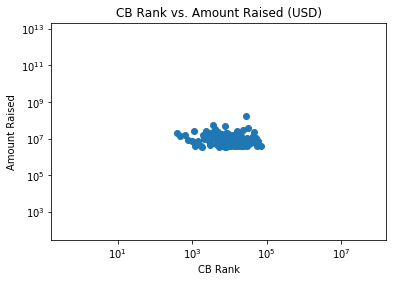

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.001963
Date:                Tue, 11 Aug 2020   Prob (F-statistic):              0.965
Time:                        12:26:03   Log-Likelihood:                -2788.4
No. Observations:                 155   AIC:                             5581.
Df Residuals:                     153   BIC:                             5587.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.091e+07   1.88e+06      5.797      0.0

In [14]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
'''
General Data
    Regress funding against CB rank
'''
X = [] ; Y = []
for i in range(len(df3)):
    pos = df1.iloc[i]
    if not math.isnan(pos['Last Funding Amount Currency (in USD)']):
        y = pos['Last Funding Amount Currency (in USD)']
        x = int(pos['CB Rank (Company)'].replace(',',''))
        X.append(x)
        Y.append(y)
plt.xscale('log') ; plt.yscale('log') ; plt.scatter(X, Y) 
plt.xlabel('CB Rank') ; plt.ylabel('Amount Raised') ; 
plt.title('CB Rank vs. Amount Raised (USD)') ; plt.show()
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

In [15]:
'''
Data Validation: Rounds
'''
keptRoundNames = {} ; droppedRoundNames = {}
for name_ in df1_.index:
    round_ = df1_.loc[name_]['Last Funding Type']
    if name_ not in alldata.keys():
        if round_ not in droppedRoundNames:
            droppedRoundNames[round_] = 1
        else:
            droppedRoundNames[round_] += 1
    else:
        if round_ not in keptRoundNames:
            keptRoundNames[round_] = 1
        else:
            keptRoundNames[round_] += 1
print("Dropped round: {}".format(str(droppedRoundNames)))
print("Kept round: {}".format(str(keptRoundNames)))

Dropped round: {'Series A': 190, 'Seed': 196}
Kept round: {'Series A': 745, 'Seed': 755}


In [16]:
'''
Loads top schools data
'''
topSchools = pd.read_csv('topSchools.csv', index_col="Score_Rank")
topSchools = topSchools[['University', 'General_name']].head(100)

In [17]:
'''
Pedigree
    1. Do the majority of successful founders attend a top university?
'''
topcount = 0 ; schoolDict = {} ; founderCount = 0 ; schoolFound = False
for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            if founder['education']:
                founderCount += 1 ; schoolFound = False
                for educ_ in founder['education']:
                    school_ = educ_['school'].lower()
                    if school_ not in schoolDict:
                        schoolDict[school_] = 1
                    else:
                        schoolDict[school_] += 1
                    if not schoolFound:
                        for topSchool_ in topSchools['University']:
                            if school_ in topSchool_.lower():
                                topcount += 1
                                schoolFound = True
                                break
                    if not schoolFound:
                        for topSchool_ in topSchools['General_name']:
                            if topSchool_ in school_.lower():
                                topcount += 1
                                schoolFound = True
                                break
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}                   
print("{} % of founders attended a Top 100 School at some point in their education".format(str(topcount / founderCount * 100)))

print("Top schools attended:")
count = 1
for k in schoolDict.keys():
    if count <= 10:
        print("{}. {}".format(str(count), k))
        count += 1
    else:
        break

df_school = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()

45.68510038746037 % of founders attended a Top 100 School at some point in their education
Top schools attended:
1. stanford university
2. y combinator
3. massachusetts institute of technology
4. university of california, berkeley
5. carnegie mellon university
6. harvard university
7. harvard business school
8. cornell university
9. university of cambridge
10. university of michigan


In [18]:
'''
Pedigree
    2. Do the majority of successful founders attend graduate school?
'''
degreeDict = {} ; degreeCount = 0 ; gradCount = 0

def checkGraduateEducation(founder, degreeDict, degreeCount):
    if founder['education']:
        checkDegree = True
        for educ_ in founder['education']:
            if educ_['degree']:
                deg_ = educ_['degree'].lower()
                if checkDegree:
                    degreeCount += 1
                    checkDegree = False
                if deg_ not in degreeDict:
                    degreeDict[deg_] = 1
                else:
                    degreeDict[deg_] += 1
    return degreeDict, degreeCount

for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            degreeDict, degreeCount = checkGraduateEducation(founder, degreeDict, degreeCount)

degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of founders have postgraduate education".format(str(gradCount / degreeCount * 100)))

10.916179337231968 percent of founders have postgraduate education


In [19]:
'''
Pedigree
    3. Do successful founders study certain fields over others?
'''
fieldDict = {}

def getFields(founder, fieldDict):
    if founder['education']:
        for educ_ in founder['education']:
            if educ_['field']:
                field = educ_['field'].lower()
                if field not in fieldDict:
                    fieldDict[field] = 1
                else:
                    fieldDict[field] += 1
    return fieldDict

for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            fieldDict = getFields(founder, fieldDict)

fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of founders that studied CS and related fields: {}%".format(str(100 * count/totalCount)))


Most commonly studied fields:
1. computer science
2. economics
3. mechanical engineering
4. electrical engineering
5. computer engineering
6. finance
7. physics
8. business administration and management, general
9. mathematics
10. marketing
Percentage of founders that studied CS and related fields: 22.478898267436694%


In [20]:
'''
Employment Background
    1. Do most founders have experience at startups (CEO, CFO, CTO, COO, Founder)
'''
posDict = {} ; ceosList = [] ; ctosList = []
for key in alldata.keys():
    if alldata[key]['founders']:
        for founder in alldata[key]['founders']:
            if founder['experience']:
                firstCheck = True ; ceoCheck = False ; ctoCheck = False
                for exp_ in founder['experience']:
                    if (not key.split(' ')[0] in exp_['companyName']):
                        if exp_['title']:
                            if 'founder' in exp_['title'].lower() and firstCheck:
                                pass
                            else:
                                pos = exp_['title'].lower()
                                if pos not in posDict:
                                    posDict[pos] = 1
                                else:
                                    posDict[pos] += 1
                            firstCheck = False
                            if not ceoCheck:
                                if 'ceo' in exp_['title'].lower() or 'executive officer' in exp_['title'].lower():
                                    ceosList.append(founder)
                                    ceoCheck = True
                            if not ctoCheck:
                                if 'cto' == exp_['title'].lower() or ' cto' in exp_['title'].lower() or 'cto ' in exp_['title'].lower() or 'technology officer' in exp_['title'].lower() or 'technical officer' in exp_['title'].lower():
                                    ctosList.append(founder)
                                    ctoCheck = True
posDict = {k: v for k, v in sorted(posDict.items(), key=lambda item: item[1], reverse=True)}

df_pos = pd.DataFrame.from_dict(posDict, orient='index', columns=['freq']).reset_index()
print("Previous titles held by founders:")
df_pos.head(10)

Previous titles held by founders:


,index,freq
0,software engineer,196
1,co-founder,180
2,board member,178
3,ceo,166
4,founder,143
5,advisor,113
6,consultant,86
7,cto,85
8,investor,73
9,senior software engineer,67


In [21]:
'''
Pedigree & Employment:
    Profiles of CEOs vs. CTOs
'''
degreeDict = {} ; degreeCount = 0 ; gradCount = 0
for cto in ctosList:
    degreeDict, degreeCount = checkGraduateEducation(cto, degreeDict, degreeCount)
    
degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of CTOs have postgraduate education".format(str(gradCount / degreeCount * 100)))

degreeDict = {} ; degreeCount = 0 ; gradCount = 0
for ceo in ceosList:
    degreeDict, degreeCount = checkGraduateEducation(ceo, degreeDict, degreeCount)

degreeDict = {k: v for k, v in sorted(degreeDict.items(), key=lambda item: item[1], reverse=True)}  
for key in degreeDict.keys():
    if key in ['mba', 'ms', 'msc', 'ph.d', 'phd', 'ma', 'jd', 'ph.d', 'md', 'mse', 'meng'] or 'master' in key or 'm.' in key or 'doctor' in key:
        gradCount += 1
print("{} percent of CEOs have postgraduate education".format(str(gradCount / degreeCount * 100)))

fieldDict = {}
for ceo in ceosList:
    fieldDict = getFields(ceo, fieldDict)
    
fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields CEO:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k or 'cs' == k or 'software' in k or 'data' in k or 'engine' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of CEOs that studied CS and engineering fields: {}%".format(str(100 * count/totalCount)))

fieldDict = {}
for cto in ctosList:
    fieldDict = getFields(cto, fieldDict)

fieldDict = {k: v for k, v in sorted(fieldDict.items(), key=lambda item: item[1], reverse=True)}
count = 0 ; totalCount = 0
computerFields = {} ; breakCount = 0
print("Most commonly studied fields CTO:")
for k in fieldDict.keys():
    if breakCount < 10:
        print("{}. {}".format(str(breakCount+1), k))
        breakCount += 1
    if 'computer' in k or 'cs' == k or 'software' in k or 'data' in k or 'engine' in k:
        count += fieldDict[k]
        computerFields[k] = fieldDict[k]
    totalCount += fieldDict[k]
df_fields = pd.DataFrame.from_dict(fieldDict, orient='index', columns=['freq']).reset_index()
df_fields.head(10)
print("Percentage of CTOs that studied CS and engineering fields: {}%".format(str(100 * count/totalCount)))

founderCount = 0 ; schoolDict = {}
for founder in ceosList:
    if founder['education']:
        founderCount += 1 ; schoolFound = False
        for educ_ in founder['education']:
            school_ = educ_['school'].lower()
            if school_ not in schoolDict:
                schoolDict[school_] = 1
            else:
                schoolDict[school_] += 1
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}
df_schoolCEOs = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()
print("CEO Schools:")
print(df_schoolCEOs.head(10))

founderCount = 0 ; schoolDict = {}
for founder in ctosList:
    if founder['education']:
        founderCount += 1 ; schoolFound = False
        for educ_ in founder['education']:
            school_ = educ_['school'].lower()
            if school_ not in schoolDict:
                schoolDict[school_] = 1
            else:
                schoolDict[school_] += 1
schoolDict = {k: v for k, v in sorted(schoolDict.items(), key=lambda item: item[1], reverse=True)}
df_schoolCTOs = pd.DataFrame.from_dict(schoolDict, orient='index', columns=['freq']).reset_index()
print("CTO Schools:")
print(df_schoolCTOs.head(10))

21.100917431192663 percent of CTOs have postgraduate education
18.202764976958523 percent of CEOs have postgraduate education
Most commonly studied fields CEO:
1. computer science
2. economics
3. business administration and management, general
4. marketing
5. finance
6. electrical engineering
7. business administration
8. law
9. mathematics
10. international business
Percentage of CEOs that studied CS and engineering fields: 26.658163265306122%
Most commonly studied fields CTO:
1. computer science
2. computer engineering
3. electrical engineering
4. information technology
5. mechanical engineering
6. physics
7. mathematics
8. software engineering
9. computer science and engineering
10. electrical and computer engineering
Percentage of CTOs that studied CS and engineering fields: 58.1578947368421%
CEO Schools:
                                         index  freq
0                          stanford university    22
1                                 y combinator    19
2        massachuset

In [22]:
'''
Employment Background (1) contd.
'''
entrepCount = 0 ; techCount = 0 ; busCount = 0 ; totalCount = 0
for i in range(len(df_pos)):
    pos = df_pos.iloc[i]
    totalCount += pos['freq']
    if 'founder' in pos['index'] or 'ceo' in pos['index'] or 'executive' in pos['index'] or 'board' in pos['index'] or 'president' in pos['index']:
        entrepCount += pos['freq']
    if ('engineer' in pos['index'] or 'cto' in pos['index'] or 'technology' in pos['index'] or 'computer' in pos['index'] or 'developer' in pos['index'] or 
        'science' in pos['index'] or 'data' in pos['index'] or 'research' in pos['index']):
        techCount += pos['freq']
    if ('business' in pos['index'] or 'analyst' in pos['index'] or 'product' in pos['index'] or 'manager' in pos['index'] or 'director' in pos['index'] or 
        'coo' in pos['index'] or 'operating' in pos['index'] or 'associate' in pos['index'] or 'financ' in pos['index'] or 'vp' in pos['index'] or 
        'consultant' in pos['index']):
        busCount += pos['freq']
print("{} percent entrepreneurial/executive".format(str(entrepCount * 100 / totalCount)))
print("{} percent tech".format(str(techCount * 100 / totalCount)))
print("{} percent business/finance/consulting".format(str(busCount * 100 / totalCount)))

22.187758478081058 percent entrepreneurial/executive
30.262613730355667 percent tech
30.055831265508687 percent business/finance/consulting


In [24]:
'''
Employment Background
    2. Do founders have a lot of LinkedIn Connections
'''
connectDict = {} ; countDict = {} ; numFounders = 0 ; totalConnections = 0
for key in alldata.keys():
    numFounders_ = 0 
    try:
        for founder in alldata[key]['founders']:
            if founder['connections']:
                num = int([j for i in founder['connections'].split(' ') for j in i.split('+')][0])
                numFounders += 1 ; totalConnections += num
                numFounders_ += 1
                if key not in connectDict:
                    connectDict[key] = num
                else:
                    connectDict[key] += num
        connectDict[key] /= numFounders_
        countDict[key] = numFounders_
    except Exception as e:
        pass

print("Average number of connections is {}".format(str(totalConnections / numFounders)))

top100count = 0 ; top100founderCount = 0
for top_ in df1['Organization Name'][:100]:
    if top_ in connectDict:
        top100count += connectDict[top_] * countDict[top_]
        top100founderCount += countDict[top_]
print("Average number of connections in Top 100: {}".format(str(top100count / top100founderCount)))

Average number of connections is 468.0364479787939
Average number of connections in Top 100: 476.81447963800906


In [25]:
'''
Employment Background
    3. Do founders come from certain job positions prior to starting their company? 
        - are they prior founders?
        - are they prior software engineers
'''
df_pos.head(10)

,index,freq
0,software engineer,196
1,co-founder,180
2,board member,178
3,ceo,166
4,founder,143
5,advisor,113
6,consultant,86
7,cto,85
8,investor,73
9,senior software engineer,67


In [31]:
'''
Employment Background
    4. Do founders come from certain companies (or industries)
'''
expDict_raw = {} ; expDict = {}
for key in alldata.keys():
    for founder in alldata[key]['founders']:
        if founder['experience']:
            for exp_ in founder['experience']:
                exp_name = exp_['companyName'].lower()
                if exp_name not in expDict_raw:
                    expDict_raw[exp_name] = 1
                else:
                    expDict_raw[exp_name] += 1
                short_name = re.split('\\s+|\\.|,', exp_name)
                for word in short_name:
                    if word in expDict.keys():
                        expDict[word] += 1
                    else:
                        expDict[word] = 1
expDict = {k: v for k, v in sorted(expDict.items(), key=lambda item: item[1], reverse=True)}
expDict;

expDict_raw = {k: v for k, v in sorted(expDict_raw.items(), key=lambda item: item[1], reverse=True)}
expDict_raw

{'facebook': 8,
 'google': 6,
 'cruise': 5,
 'solutech, inc.': 5,
 'techstars': 4,
 'y combinator': 4,
 'startup weekend': 4,
 'oracle': 3,
 'wit.ai (acquired by facebook)': 3,
 'freelance': 3,
 'dashride': 3,
 'sobrio, llc': 3,
 'talent sonar': 3,
 'european innovation academy': 3,
 'communitech': 3,
 'vertisense inc.': 3,
 'joany': 2,
 'humanize health': 2,
 'assembly made': 2,
 'mckinsey & company': 2,
 'twitter full-time': 2,
 'aiden.ai': 2,
 'apple': 2,
 'nabla': 2,
 'nuance communications': 2,
 'university of connecticut': 2,
 'salesforce': 2,
 'griddable.io': 2,
 'jobvention': 2,
 'microsoft': 2,
 'clusterhq': 2,
 'cava capital': 2,
 'confirm': 2,
 'amazon': 2,
 'drone complier': 2,
 'looker': 2,
 'artillery games': 2,
 'nomiku': 2,
 'candor': 2,
 'scaphold, inc.': 2,
 'zen99': 2,
 'riseml': 2,
 'ibm': 2,
 'expensebot': 2,
 'freeagent': 2,
 'the american institute of architects, iowa chapter': 2,
 'perfect dashboard': 2,
 'perfect web extensions (acquired by ostraining)': 2,
 'p

In [32]:
'''
Employment Background
    5. Are there certain words or phrases in a founder's prior job description that stand out
'''
expDict

{'': 129,
 'full-time': 67,
 'inc': 62,
 'of': 38,
 'the': 27,
 'university': 22,
 'llc': 19,
 '&': 14,
 'freelance': 13,
 '-': 12,
 'self-employed': 11,
 '(acquired': 11,
 'by': 11,
 'and': 11,
 'ai': 10,
 'health': 9,
 'company': 9,
 'facebook': 9,
 'part-time': 9,
 'for': 9,
 'systems': 9,
 'technology': 9,
 'corporation': 9,
 '|': 9,
 'perfect': 9,
 'center': 8,
 'group': 8,
 'digital': 8,
 'capital': 8,
 'web': 7,
 'media': 7,
 'io': 7,
 'com': 7,
 'google': 7,
 'institute': 7,
 'school': 7,
 'cruise': 6,
 'ltd': 6,
 'solutions': 6,
 'innovation': 6,
 'partners': 6,
 'tech': 6,
 'energy': 6,
 'technologies': 6,
 'haven': 6,
 'academy': 6,
 'consulting': 6,
 'solutech': 6,
 'scroll': 6,
 'engineering': 6,
 'techstars': 5,
 'software': 5,
 'america': 5,
 'science': 5,
 'a': 5,
 'business': 5,
 'ventures': 5,
 'network': 5,
 'association': 5,
 'venture': 5,
 'new': 5,
 'labs': 4,
 'dashride': 4,
 'y': 4,
 'combinator': 4,
 'salesforce': 4,
 'networks': 4,
 'blue': 4,
 'amazon': 4,
 '

In [26]:
'''
Company Fundamentals 
    1. How important is the company's CB rank?
'''
ranks = [int(i.replace(',','')) for i in df1['CB Rank (Company)']]
print("Mean CB rank is: {}".format(np.mean(ranks)))
print("Among the top 200 companies, the mean rank is {}".format(str(np.mean(ranks[:200]))))

Mean CB rank is: 25734.267711598746
Among the top 200 companies, the mean rank is 14329.065


In [27]:
'''
Company Fundamentals
    2. Are there keywords in a company's description?
'''
descriptionWords = {}
for des_ in df1['Description']:
    for word in re.split('\\s|\.|,',des_):
        if word:
            if word not in descriptionWords:
                descriptionWords[word] = 1
            else:
                descriptionWords[word] += 1
descriptionWords = {k: v for k, v in sorted(descriptionWords.items(), key=lambda item: item[1], reverse=True)}
descriptionWords

{'and': 1013,
 'is': 775,
 'a': 721,
 'to': 577,
 'for': 523,
 'the': 470,
 'that': 416,
 'platform': 378,
 'software': 301,
 'of': 291,
 'an': 195,
 'in': 195,
 'company': 162,
 'with': 153,
 'data': 150,
 'management': 131,
 'provides': 130,
 'helps': 111,
 'their': 103,
 'SaaS': 101,
 'on': 100,
 'AI': 94,
 'technology': 90,
 'develops': 78,
 'solutions': 77,
 'companies': 76,
 '&': 73,
 'your': 71,
 'businesses': 67,
 'by': 67,
 'digital': 63,
 'intelligence': 62,
 'offers': 62,
 'business': 60,
 'solution': 59,
 'mobile': 57,
 'cloud': 56,
 'analytics': 49,
 'enables': 47,
 'The': 46,
 'designed': 46,
 'enterprise': 45,
 'from': 45,
 'services': 44,
 'applications': 43,
 'development': 43,
 'more': 43,
 'Platform': 43,
 'online': 42,
 'provider': 42,
 'help': 42,
 'teams': 42,
 'service': 41,
 'app': 40,
 'customer': 40,
 'marketing': 40,
 'tools': 40,
 'all': 40,
 'learning': 38,
 'based': 38,
 'as': 38,
 'industry': 38,
 'manage': 38,
 'into': 37,
 'create': 36,
 'make': 36,
 'S

In [35]:
'''
Company Fundamentals
    3. Number of founders / company location?
    Seems to be covered in General Data above
'''
df3

,Organization Name URL,Industries,Description,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,CB Rank (Company),Number of Funding Rounds,LinkedIn,Website,Founders,Estimated Revenue Range,Trend Score (90 Days),Top 5 Investors,Headquarters Location,Investment Stage,Organization Name
Organization Name,,,,,,,,,,,,,,,,,,
JOANY,https://www.crunchbase.com/organization/impact...,"Health Care, Insurance, Internet, SaaS",Joany is your trusted healthcare concierge. We...,13000000.0,USD,13000000.0,Series A,410,7,https://www.linkedin.com/company/joany/?origin...,https://Joany.com,"Christine Carrillo, Helen Lee",$1M to $10M,9.7,"Techstars, Precursor Ventures, Right Side Capi...","Los Angeles, California, United States",NaN,JOANY
Assembly,https://www.crunchbase.com/organization/assembly,"Apps, Collaboration, Crowdsourcing, Software, ...",Assembly is a web collaboration platform that ...,NaN,NaN,NaN,Seed,"5,967",3,https://www.linkedin.com/company/assembly-inc,http://assemblymade.com,"Chris Lloyd, Dave Newman, Matthew Deiters",NaN,7.6,"Y Combinator, Floodgate, BoxGroup, Union Squar...","San Francisco, California, United States",NaN,Assembly
Filament,https://www.crunchbase.com/organization/filame...,"Bitcoin, Blockchain, Hardware, Industrial, Int...",Filament builds blockchain hardware and& softw...,15000000.0,USD,15000000.0,Series A,"6,356",8,https://www.linkedin.com/company/filament-netw...,https://filament.com,"Allison Clift-Jennings, Jeremie Miller, Sally ...",Less than $1M,-0.6,"AngelList, Digital Currency Group, Techstars, ...","Reno, Nevada, United States",NaN,Filament
Nudge.ai,https://www.crunchbase.com/organization/nudge-2,"B2B, CRM, Sales, Sales Automation, Social CRM,...",Nudge is a Modern Sales Platform that leverage...,6500000.0,CAD,4970448.0,Seed,"9,064",1,http://www.linkedin.com/company/nudgeai,https://nudge.ai,"Paul Teshima, Steven Woods",Less than $1M,-0.3,"OMERS Ventures, Jill Rowley, Neal Dempsey, Bra...","Toronto, Ontario, Canada",NaN,Nudge.ai
Aiden,https://www.crunchbase.com/organization/aiden-2,"Analytics, Artificial Intelligence, Computer, ...",Aiden provides an AI analytics platform intend...,1400000.0,EUR,1601801.0,Seed,"14,044",2,https://www.linkedin.com/company/aiden.ai/,http://aiden.ai/,"Marie Outtier, Pierre-Jean Camillieri",NaN,-1.0,"Partech, Kima Ventures, Sophia Bendz, Pierre V...","London, England, United Kingdom",NaN,Aiden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dockbit,https://www.crunchbase.com/organization/dockbit,"Developer Platform, Developer Tools, Enterpris...",Dockbit turns your software deployments into r...,NaN,NaN,NaN,Seed,"378,771",1,https://www.linkedin.com/company/Dockbit,https://dockbit.com/,"Ahmed ElGamil, Tair Assimov",NaN,-0.7,NUMA Barcelona,"Barcelona, Catalonia, Spain",NaN,Dockbit
Rubicore,https://www.crunchbase.com/organization/rubicore,"Human Resources, Software","At Rubicore, our mission is to enhance perform...",NaN,NaN,NaN,Seed,"425,410",1,https://www.linkedin.com/company/3577242?trk=t...,http://www.rubicoredesigns.com,Nana Dooreck,NaN,-0.6,NaN,"Santa Monica, California, United States",NaN,Rubicore
CareerSofia,https://www.crunchbase.com/organization/career...,"SaaS, Sales",Knowledge Management for Sales Teams,NaN,NaN,NaN,Seed,"437,415",1,https://www.linkedin.com/company/careersofia,http://www.careersofia.com,Josh Reback,NaN,-0.5,NaN,"San Francisco, California, United States",NaN,CareerSofia


In [36]:
''' Saves the extracted data to a CSV'''

df_schools = pd.DataFrame.from_dict(schools, orient='index', columns=['freq'])
df_schools.sort_values(['freq'], ascending=False).to_csv('Failed_schools.csv')

df_fields = pd.DataFrame.from_dict(fields, orient='index', columns=['freq'])
df_fields.sort_values(['freq'], ascending=False).to_csv('Failed_fields.csv')

df_compnames = pd.DataFrame.from_dict(companynames, orient='index', columns=['freq'])
df_compnames.sort_values(['freq'], ascending=False).to_csv('Failed_companynames.csv')

df_titles = pd.DataFrame.from_dict(jobtitle, orient='index', columns=['freq'])
df_titles.sort_values(['freq'], ascending=False).to_csv('Failed_titles.csv')

NameError: name 'schools' is not defined